In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy.ndimage import label, binary_closing

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [29]:
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array
B1 = data + 10 *np.sin(2 * np.pi * 5 * t) + 50 * np.sin(2 * np.pi * 12.5 * t)
B2 = data + 40 *np.sin(2 * np.pi * 5 * t) + 10*np.sin(2 * np.pi * 12.5 * t)
B = np.vstack((B1,B2))

print(B.shape)

(2, 5000)


#### Create Transform Object and Analysis Filters

In [44]:
# Initializing the Transform object automatically forms the analysis and synthesis filter bank during __init__
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Morlet(1,10),
    #pad_method=None, # Padding method for the convolution calls np.pad. Set to None if no padding
    Mc = 1
)
transform.enforce_orthagonality()

Text(0.5, 0, 'Frequency Channel')

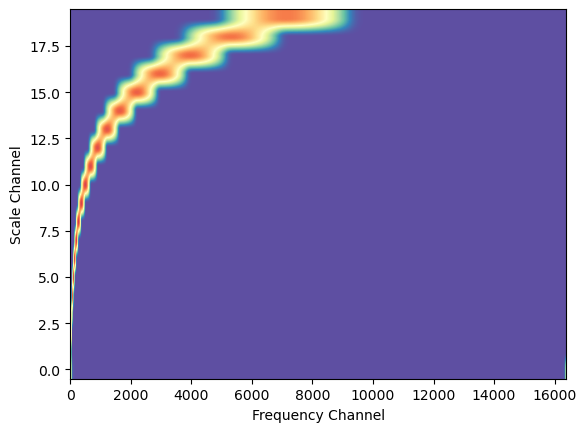

In [45]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

#### Transform


In [38]:
# Perform forward wavelet transform
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

dw = w2-w1
wc1 = np.sum(dw*w1.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)
wc2 = np.sum(dw*w2.conj(), axis=1) / np.sum(np.abs(w1)**2, axis=1)

# Calculate the K factor
k_hat = np.mean(dw*w2.conj() / (dw*w1.conj()) , axis=1).real
k_hat_original = np.copy(k_hat)
# Check the condition of each sub-sensing matrix
mixing_matrices = np.empty((len(k_hat), 2, 2))
mixing_matrices[:, 0, :] = [1, 1]          # First row is always [1, 1]
mixing_matrices[:, 1, 0] = 1               # Second row first column is 1
mixing_matrices[:, 1, 1] = k_hat           # Second row second column is k_hat

# Compute singular values for all matrices at once
try:
    _, s, _ = np.linalg.svd(mixing_matrices)
    condition_numbers = s[:, 0] / s[:, 1]
    valid_mask = condition_numbers < 10
except:
    valid_mask = (k_hat < .7) | (k_hat > 1.6)

valid_mask = binary_closing(valid_mask, structure=np.ones(5))
#valid_mask = binary_dilation(valid_mask, structure=np.ones(50))

# Label contiguous segments
labeled_mask, num_segments = label(valid_mask)

# Process each segment

for seg_id in range(1, num_segments + 1):
    # Extract frequency bins in the current segment
    segment_mask = labeled_mask == seg_id
    k_segment = k_hat[segment_mask]

    if(np.mean(k_segment) < 1):
        k_hat[segment_mask] = np.min(k_segment)
    else:
        k_hat[segment_mask] = np.max(k_segment)



# Apply K to compute clean signal
k = k_hat[:, np.newaxis]

w_clean = np.copy(w1)/2 + np.copy(w2) / 2
w_clean[valid_mask] = (k[valid_mask] * w1[valid_mask] - w2[valid_mask]) / (k[valid_mask] - 1)


# Find nan values and replace them with the average of the two sensors
nan_mask = np.isnan(w_clean[:, 0])
weights_1 = 1/(np.abs(wc1) +1)[:, np.newaxis]
weights_2 = 1/(np.abs(wc2) +1)[:, np.newaxis]
w_clean[nan_mask] = (weights_1[nan_mask]*w1[nan_mask]+ weights_2[nan_mask]*w2[nan_mask]) / (weights_1[nan_mask] + weights_2[nan_mask])



result = transform.inverse(np.copy(w_clean))


Raw Error:  36.03376552017705
Raw Error:  29.256676344870982
Cleaned Error:  2.1353086914817827


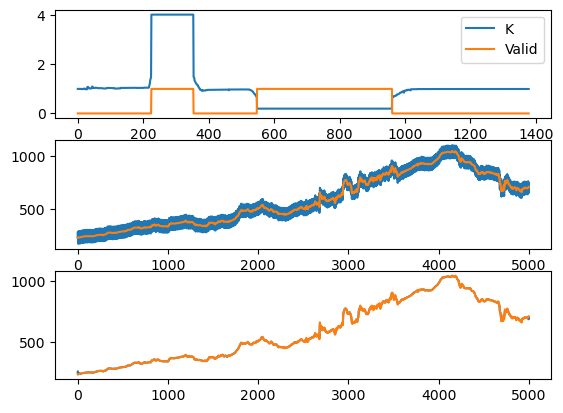

In [46]:
print("Raw Error: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[200:-200]-result[200:-200])**2).mean(axis=0)))

fig, ax = plt.subplots(3,1)
ax[0].plot(k_hat, label='K')
ax[0].plot(np.array(valid_mask, dtype=int), label='Valid')
ax[0].legend()
ax[1].plot(B[0])
ax[1].plot(data)
ax[2].plot(result)
ax[2].plot(data)

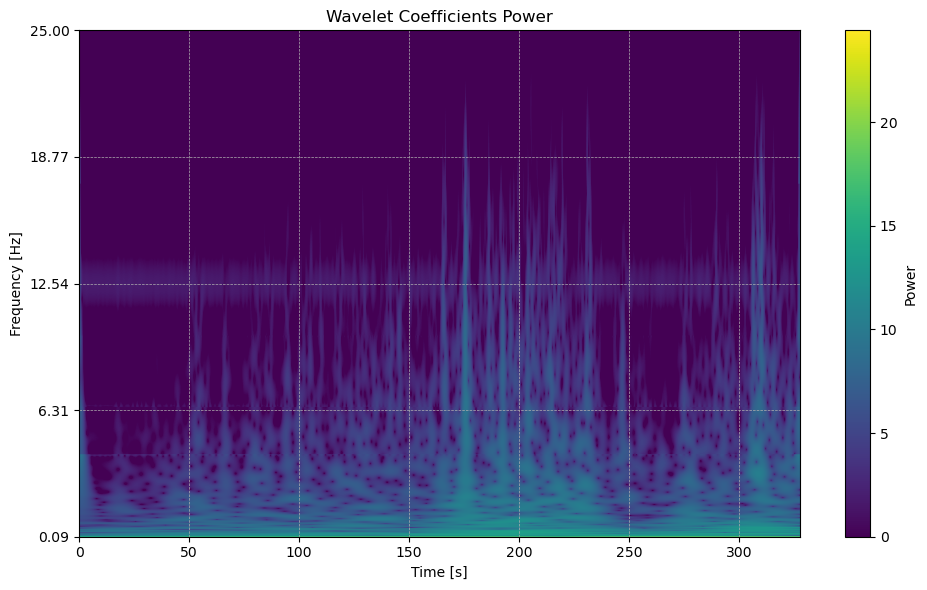

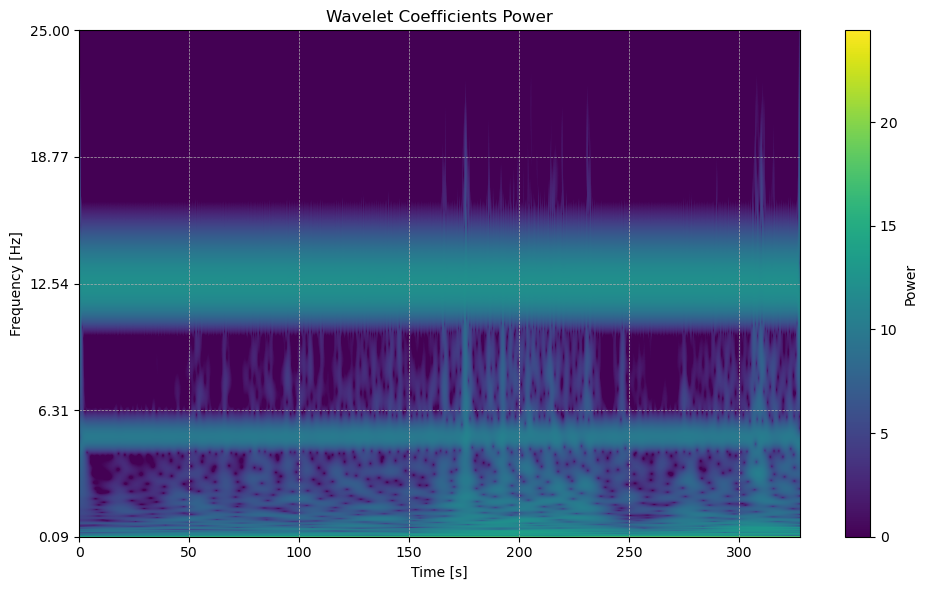

In [41]:
transform.scalogram(w_clean, vmin=0)
transform.scalogram(w1,vmin=0)

#### Compare to Normal WAICUP

(2.4127574962551863+0j)


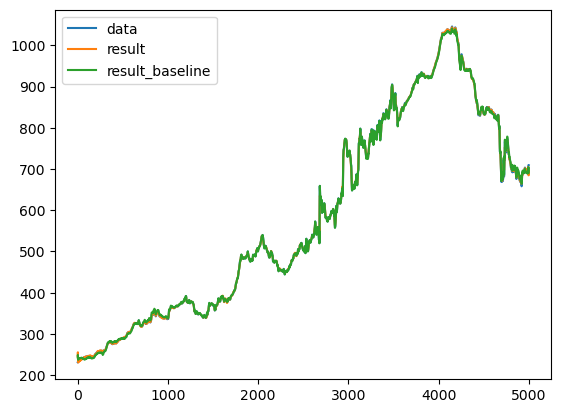

In [43]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result')
plt.plot(result_baseline, label='result_baseline')
plt.legend()

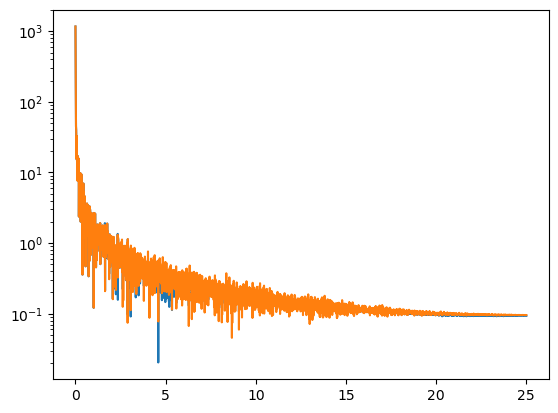

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


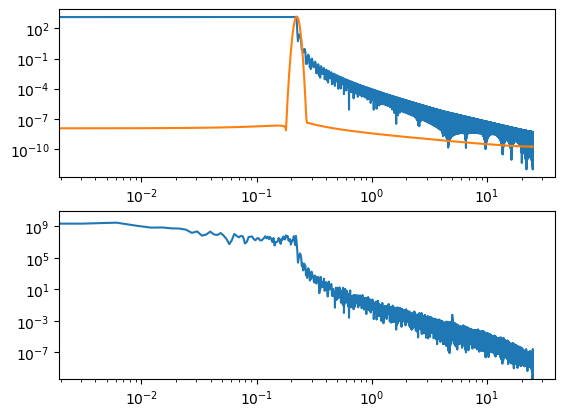

In [18]:
fig, ax = plt.subplots(2,1)
i = 0
N = w1.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i+1][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(w1, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')